In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
batchSize = 32
imageShape = (224, 224)
epochs = 10
channels = 3

In [3]:
train_dir = "/kaggle/input/tomatoleaf/tomato/train/"
val_dir = "/kaggle/input/tomatoleaf/tomato/val/"

In [4]:
class_names = sorted(os.listdir(train_dir))
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
class_dis

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

In [6]:
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

In [7]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

In [8]:
train_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [9]:
test_ds = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')

Found 1000 images belonging to 10 classes.


In [10]:
def plot_images(data, class_names):
    
    r, c = 3, 4
    imgLen = r*c
    
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        
        id = np.random.randint(len(images))
#         img = images[id].numpy().astype('uint8')
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
    plt.show()
    

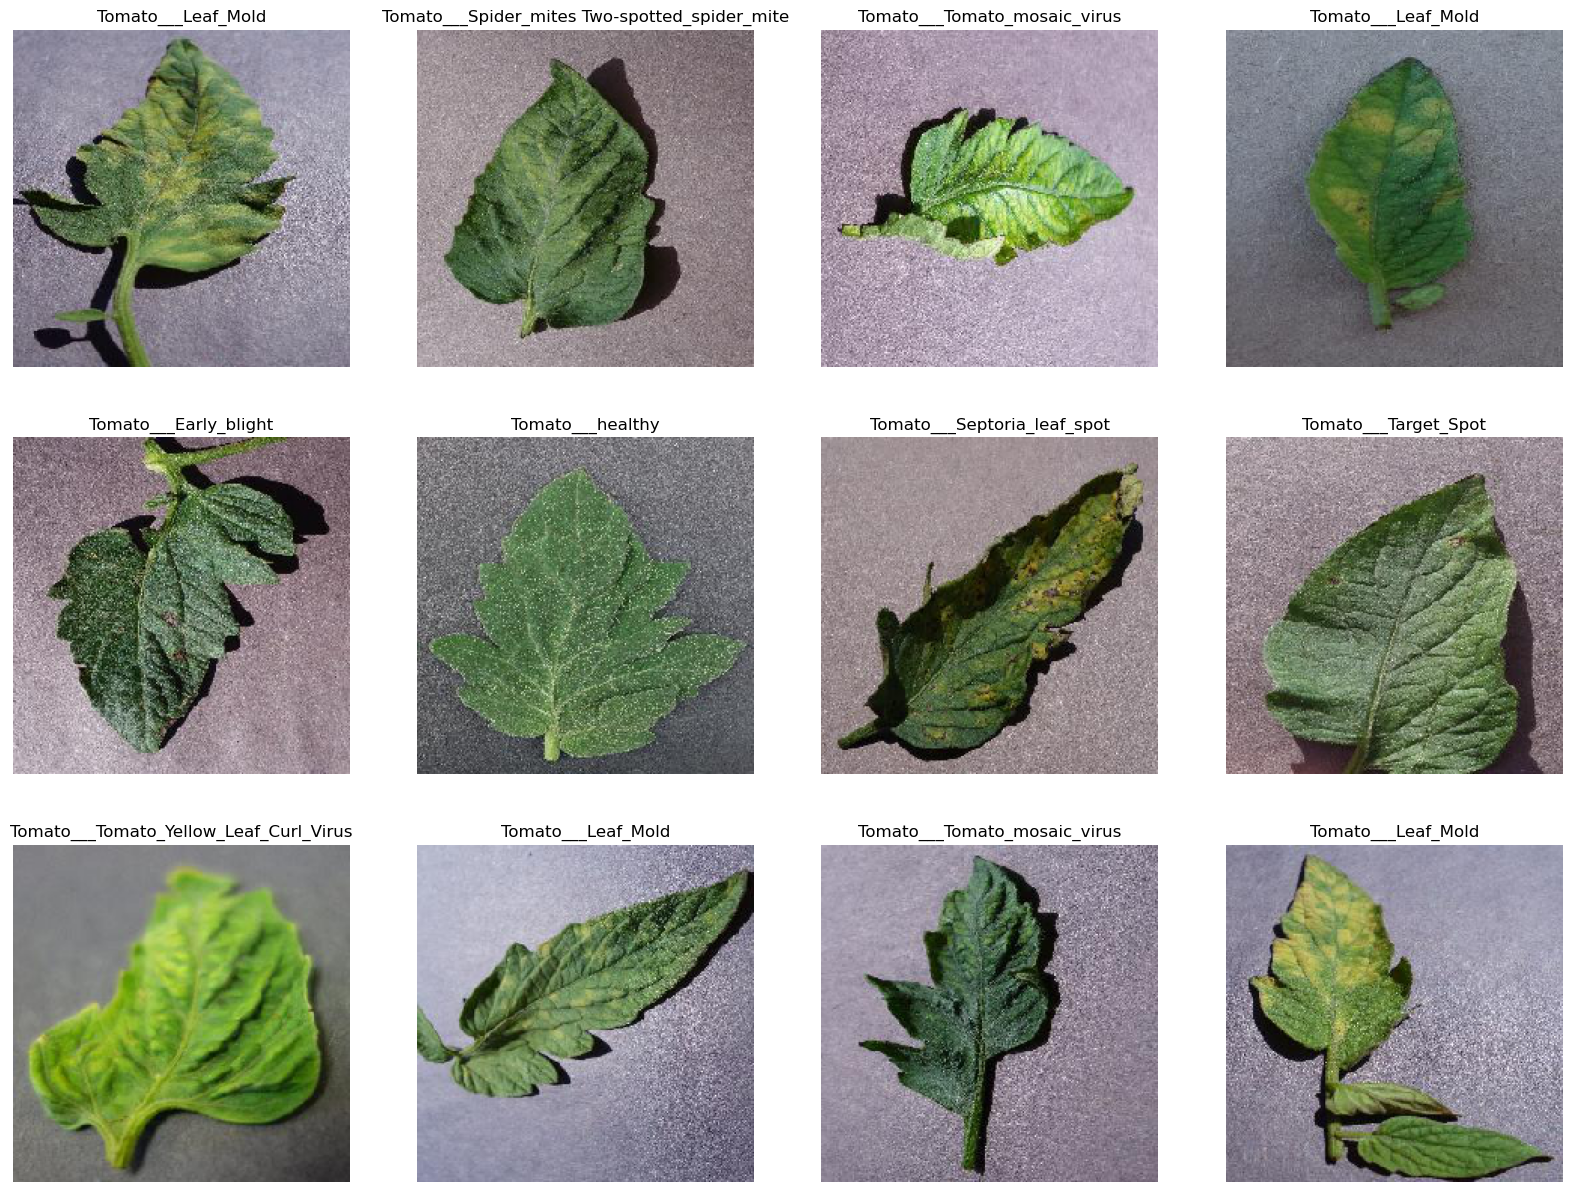

In [11]:
plot_images(train_ds, class_names)

In [12]:
def get_model():
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layers in base_model.layers:
        layers.trainable = False
        
    base_model_output = base_model.output
    
    x = Flatten()(base_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [13]:
model = get_model()

model.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [14]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/10
250/250 [==============================] - 122s 428ms/step - loss: 1.6248 - accuracy: 0.5270 - val_loss: 0.7092 - val_accuracy: 0.7605
Epoch 2/10
250/250 [==============================] - 35s 139ms/step - loss: 0.6887 - accuracy: 0.7602 - val_loss: 0.5564 - val_accuracy: 0.8100
Epoch 3/10
250/250 [==============================] - 35s 140ms/step - loss: 0.4744 - accuracy: 0.8374 - val_loss: 0.5634 - val_accuracy: 0.7930
Epoch 4/10
250/250 [==============================] - 35s 140ms/step - loss: 0.3402 - accuracy: 0.8886 - val_loss: 0.5335 - val_accuracy: 0.8220
Epoch 5/10
250/250 [==============================] - 36s 142ms/step - loss: 0.2337 - accuracy: 0.9225 - val_loss: 0.4849 - val_accuracy: 0.8360
Epoch 6/10
250/250 [==============================] - 35s 141ms/step - loss: 0.1669 - accuracy: 0.9463 - val_loss: 0.7105 - val_accuracy: 0.7670
Epoch 7/10
250/250 [==============================] - 35s 142ms/step - loss: 0.0987 - accuracy: 0.9737 - val_loss: 0.4415 - val_a

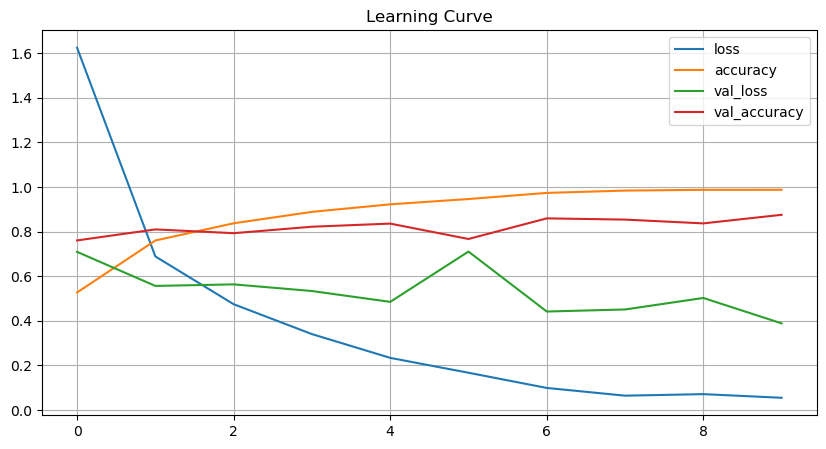

In [15]:
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Learning Curve")
plt.grid()

In [16]:
def predictImages(data, class_names, model):
    
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]
        
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
            
    plt.show()

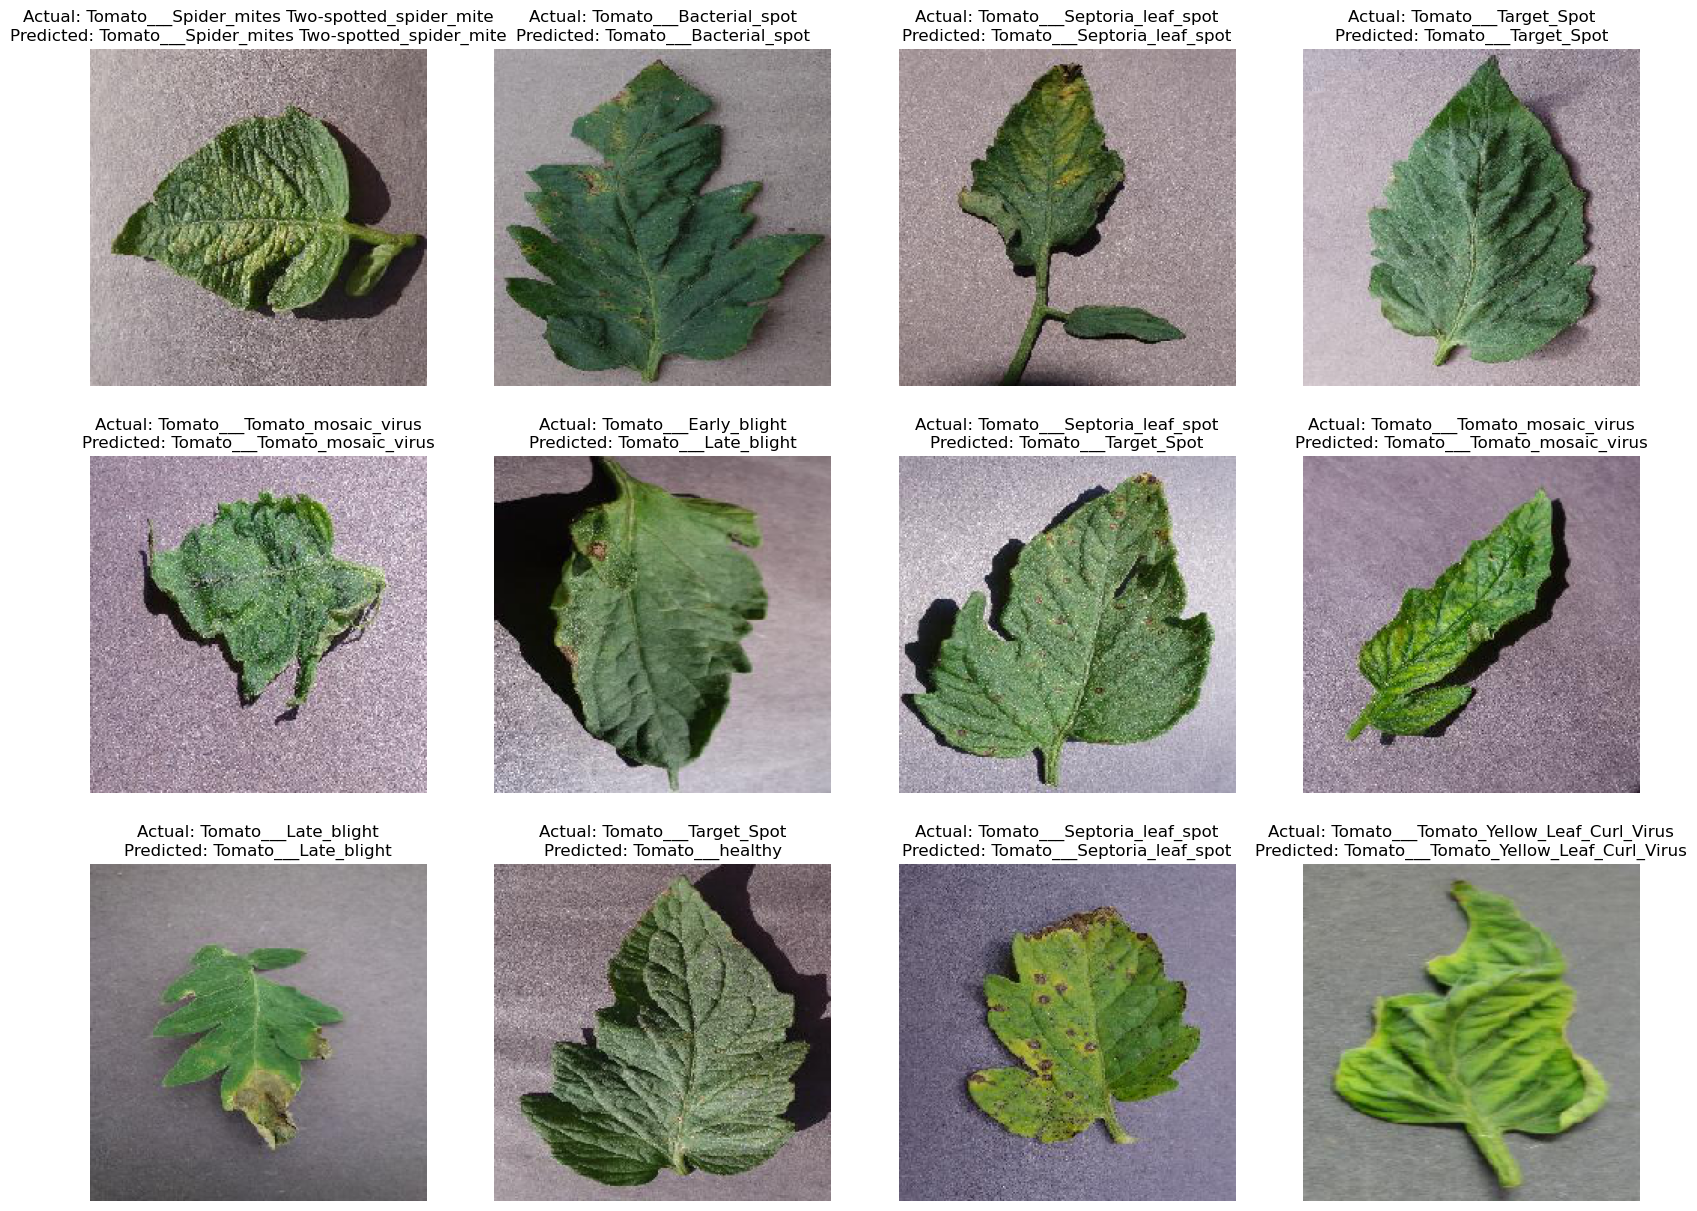

In [17]:
predictImages(test_ds, class_names, model)

In [18]:
model.save("model.h5")


In [19]:
import pickle

# Save model as pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [21]:
# Get predictions from the model on the test dataset
y_pred = np.argmax(model.predict(test_ds), axis=1)


32/32 [==============================] - 10s 280ms/step


In [22]:
y_pred.size

1000

In [23]:

# Get the true labels from the test dataset
y_true = test_ds.classes

In [24]:
y_true.size

1000

In [25]:
print(confusion_matrix(y_true, y_pred))

[[15  7  9  9 12 15  7  5 10 11]
 [10  7 12  9 14  8  7 13 10 10]
 [ 7 12 13  6 10  9  8 11 16  8]
 [12  7 12 10  7 12  6 11 13 10]
 [11  8 13  8  7  4 16  7 12 14]
 [ 7  9 15 12  8  9 11 12 10  7]
 [15 14 11 13  9 14 13  4  5  2]
 [15  9 13 10  7 11  5 10 10 10]
 [13  8 11 12  7 15  4 11 12  7]
 [13  9  4 14  6  9  7 14  9 15]]
